In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [4]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

--2020-04-19 19:04:25--  https://s3.amazonaws.com/rlx/mini_cifar_2.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9943835 (9.5M) [application/x-www-form-urlencoded]
Saving to: ‘mini_cifar_2.h5’

mini_cifar_2.h5     100%[===================>]   9.48M   546KB/s    in 15s     

2020-04-19 19:04:40 (666 KB/s) - ‘mini_cifar_2.h5’ saved [9943835/9943835]



(0.0, 1.0)

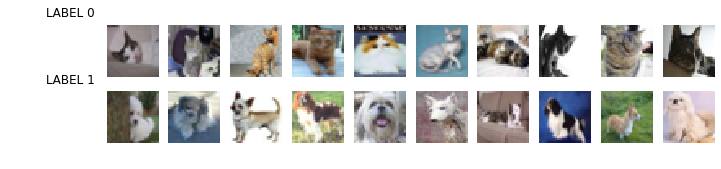

In [5]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
1    405
0    395
dtype: int64

distribution of test classes
0    108
1     92
dtype: int64


## Part 1: train a model from SCRATCH with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [9]:
def get_model(num_classes, img_size=32, compile=True):

    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3),name="Input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)#,trainable=trainable
    layers = tf.keras.layers.MaxPool2D(2,2)(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.3)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [10]:
num_classes = len(np.unique(y_cifar))
model = get_model( num_classes )
model.summary()

using 2 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3904      
_________________________________________________________________
dense_1 (Dense)              (None, 64)      

In [11]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned" )

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 3s 4ms/sample - loss: 0.7053 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4700
Epoch 2/15
800/800 [==============================] - 4s 5ms/sample - loss: 0.6934 - accuracy: 0.5150 - val_loss: 0.6930 - val_accuracy: 0.4500
Epoch 3/15
800/800 [==============================] - 3s 4ms/sample - loss: 0.6945 - accuracy: 0.4888 - val_loss: 0.6938 - val_accuracy: 0.4600
Epoch 4/15
800/800 [==============================] - 3s 4ms/sample - loss: 0.6927 - accuracy: 0.5075 - val_loss: 0.6928 - val_accuracy: 0.4850
Epoch 5/15
800/800 [==============================] - 2s 3ms/sample - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6920 - val_accuracy: 0.5400
Epoch 6/15
800/800 [==============================] - 2s 3ms/sample - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.4750
Epoch 7/15
800/800 [==============================] - 2s 3ms/sample - loss: 0.6932 - accur

{'loss': 0.6954744625091552, 'accuracy': 0.475}

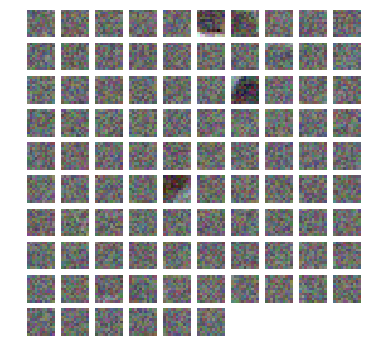

In [13]:
mlutils.display_imgs(model.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [15]:
from tensorflow.keras.models import load_model

model1 = get_model(num_classes)
model2 = load_model("alexnet_finetuned_minicifar.model" )
model2.summary()

using 2 classes
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)    

In [16]:
w1 = model1.get_weights() # obtain weights of model 1
w2 = model2.get_weights() # obtain weights )of model 2

In [18]:
for i in w1:
    print(i.shape)# print all weights shapes of model 1

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 64)
(64,)
(64, 64)
(64,)
(64, 2)
(2,)


In [19]:
for i in w2:
    print(i.shape) # print all weights shapes of model 2

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [20]:
for i in range(3):
    w1[i]=w2[i]
    print(w1[i].shape)

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)


In [21]:
model1.set_weights(w1)

### train!!!

In [22]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 3s 3ms/sample - loss: 0.6920 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.5100
Epoch 2/15
800/800 [==============================] - 3s 4ms/sample - loss: 0.6923 - accuracy: 0.5025 - val_loss: 0.6944 - val_accuracy: 0.4650
Epoch 3/15
800/800 [==============================] - 3s 4ms/sample - loss: 0.6875 - accuracy: 0.5263 - val_loss: 0.6973 - val_accuracy: 0.4400
Epoch 4/15
800/800 [==============================] - 3s 3ms/sample - loss: 0.6853 - accuracy: 0.5238 - val_loss: 0.6973 - val_accuracy: 0.4750
Epoch 5/15
800/800 [==============================] - 2s 3ms/sample - loss: 0.6872 - accuracy: 0.5275 - val_loss: 0.6965 - val_accuracy: 0.4700
Epoch 6/15
800/800 [==============================] - 2s 3ms/sample - loss: 0.6758 - accuracy: 0.5412 - val_loss: 0.7193 - val_accuracy: 0.5100
Epoch 7/15
800/800 [==============================] - 3s 3ms/sample - loss: 0.6649 - accur

{'loss': 0.8524057817459106, 'accuracy': 0.64}

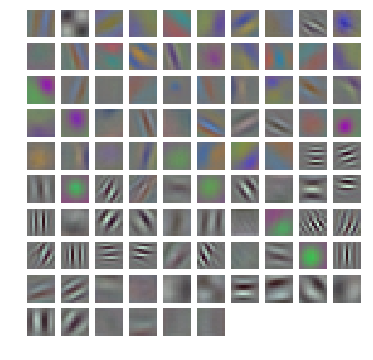

In [23]:
mlutils.display_imgs(model1.get_weights()[0])